In [2]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta

In [7]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

                           Close_Price  Regular_Returns
Date                                                   
2020-05-04 00:00:00-04:00    71.300346         0.014049
2020-05-05 00:00:00-04:00    72.370506         0.014898
2020-05-06 00:00:00-04:00    73.117157         0.010264
2020-05-07 00:00:00-04:00    73.873550         0.010292
2020-05-08 00:00:00-04:00    75.631866         0.023523
...                                ...              ...
2022-06-23 00:00:00-04:00   136.565094         0.021344
2022-06-24 00:00:00-04:00   139.913269         0.024221
2022-06-27 00:00:00-04:00   139.913269         0.000000
2022-06-28 00:00:00-04:00   135.745331        -0.030242
2022-06-29 00:00:00-04:00   137.513260         0.012940

[544 rows x 2 columns]


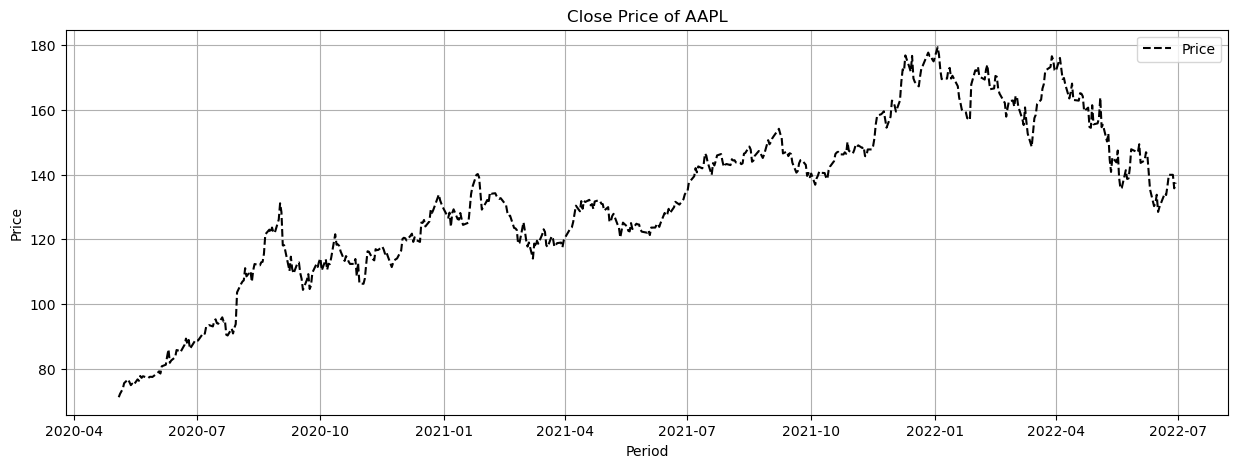

None
('2020-05-04', 71.30034637451172)


In [93]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):
    """
      Args:
      symbol (str): The ticker symbol of the stock being analyzed (e.g., 'AAPL').
      start (str): The start date of the backtesting period in 'YYYY-MM-DD' format.
      end (str): The end date of the backtesting period in 'YYYY-MM-DD' format.
      interval (str): The data interval for trades, e.g., '1d' for daily data.
      capital (float): The initial amount of capital to start trading with.
      transaction_cost (float): The transaction cost as a decimal, e.g., 0.01 for 1%.

    """
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital
    self.capital = capital
    self.transaction_cost = transcation_cost
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade detail. the only change to store all the data
    self.prepare_data() # 

  def prepare_data(self):
    """
    Retrieves and calculates the regular returns of the stock and stores in self.data as a dataframe

    Returns:
      None
    """
    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    stock_df = pd.DataFrame()
    stock_df["Close_Price"] = hist_stock["Close"]
    stock_df["Regular_Returns"] = np.log(stock_df["Close_Price"] / stock_df["Close_Price"].shift(1))
    stock_df = stock_df.dropna()
    self.data = stock_df

  def close_price_graph(self):
    """
    Plots a line graph of the close price of the symbol from the start to the end date

    Returns:
      None
    """
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.title("Close Price of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, time_index):
    """
    Retrieves the date and closing price of the stock at a specified time index
    
    Args:
      time_index (int) = The index in the time series data representing a specific date.

    Returns:
      tuple: A tuple containing:
        - date (str): The date at the specified index in "YYYY-MM-DD" format.
        - price (float): The closing price of the stock on the specified date.

    Example:
      >>> return_date_price(0)
      ("2020-01-01", 159)
    """

    date = str(self.data.index[time_index])[:10]
    price = self.data.Close_Price.iloc[time_index]
    return date, price

  def realised_balance(self, time_index):
    """
    Calculates and displays the realised balance (available cash or liquid capital) in the account at a specific point in timee
    
    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None
      
    Example:
      >>> self.realised_balance(10)
      Date :2022-05-01 | Realised Balance: 10000.0
    """

    date, price = self.return_date_price(time_index)
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, time_index):
    """
    Calculates and displays the unrealised balance, representing the current market value of open positions, in the account at a specified time.

    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None

    Example:
      >>> self.unrealised_balance(10)
      Date :2022-05-01 | Unrealised Balance: 5000.0
    """
    date, price = self.return_date_price(time_index)
    # self.quantity = quantities to buy or sell
    ub = self.quantity *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, time_index):
    """
    Calculates and displays the total balance, including both realised (cash) and unrealised (open positions) balances, at a specified time.

    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None

    Example:
      >>> self.total_balance(10)
      Date :2022-05-01 | Total Balance: 15000.0
    """
    date, price = self.return_date_price(time_index)
    tb = self.quantity *price + self.capital

    print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    """
    Records the details of each trade into a dataframe for tracking and analysis purposes.
    Appends the trade details (trade ID, date, position, price, symbol, quantity, and capital)
    as a new row in `self.stored_data`.

    Args:
      trade (int): Either 0 for no trade or the current total number of trades executed.
      date (str): The date of the trade, formatted as 'YYYY-MM-DD'.
      position (int): The trade position, with 1 for long, -1 for short, and 0 for no position.
      price (float): The price at which the trade was executed.
      symbol (str): The ticker symbol of the asset being traded.
      quantity (int): The number of shares or units involved in the trade.
      capital (float): The total capital after executing the trade.

    Returns:
      None

    Example:
      >>> self.store_results(2, '2022-05-01', 1, 150.0, 'AAPL', 10, 10000.0)
      Appends a new row to `self.stored_data` with the trade details for 'AAPL' on 2022-05-01, marking the 2nd trade.
      >>> self.store_results(0, '2022-05-02', 0, 0, 'AAPL', 0, 10000.0)
      Appends a new row indicating no trade was made on '2022-05-02'.
    """
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def buy_order(self, time_index, trades, quantity=None, dollar=None):
    """
    Buys shares for the self.symbol by either quantity or dollar amount. Adjusts capital to reflect transaction costs, updates position status, and stores the transaction details.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      trades (int): Number representing the number of trades that has been done
      quantity (int, optional): Number of shares to buy. If None, the quantity is calculated based on the dollar argument.
      dollar (float, optional): Dollar amount to spend on the buy order. Defaults to None.

    Returns:
      None

    Example:
      >>> self.buy_order(100, dollar=5000)
      Bought 10 shares of AAPL at 150.0 per share worth $1500.0

    Notes:
      - If `quantity` is not provided, it is calculated as `dollar / price`.
      - The capital is reduced based on the transaction cost.
    """
    date, price = self.return_date_price(time_index) # the current date and price
    if quantity == None: # if the dollar value of the buy order is specified
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity = self.quantity + quantity
    trades = trades + 1
    self.position = 1 #(To be stored in results. Will need for calculations)
    self.store_results(trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)

    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(time_index)
      self.unrealised_balance(time_index)
      self.total_balance(time_index)

  def sell_order(self, time_index, trades, quantity=None, dollar=None):
    """
    Sells shares of the specified symbol by either quantity or dollar amount. Adjusts capital to account for transaction costs, updates position status, and stores the transaction details.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to sell. If None, the quantity is calculated based on the dollar argument.
      dollar (float, optional): Dollar amount to generate from the sell order. Defaults to None.

    Returns:
      None

    Example:
      >>> self.sell_order(100, quantity=10)
      Sold 10 shares of AAPL at 150.0 per share worth 1500.0 $

    Notes:
      - If `quantity` is not provided, it is calculated as `dollar / price`.
      - The capital is increased based on the transaction cost.
    """
    date, price = self.return_date_price(time_index)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity = self.quantity - quantity
    trades = trades + 1
    self.position = -1
    self.store_results(trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(time_index)
      self.unrealised_balance(time_index)
      self.total_balance(time_index)

  def last_trade(self, time_index, trades):
    """
    Finalizes the open position by closing any remaining shares. Closes out any remaining shares by calculating the last trade. Updates the capital and position, logs the last trade, and outputs the final balance.

    Args:
      time_index (int): Index representing the specific point in time for the final trade.

    Returns:
        None

    Example:
      >>> self.last_trade(100)
      Closed open trades for 10 shares of AAPL at 150.0 per share worth 1500.0 $
        
    Notes:
      - If in a short position (`position == -1`), the position is bought to close with a positive quantity.
      - Adjusts capital by selling all remaining shares at the final price.
    """
    date, price = self.return_date_price(time_index)
    last_quantity = self.quantity
    self.capital = self.capital + last_quantity * price
    self.quantity = 0 # as no more quantity now. all will be settled
    trades = trades +1
    if self.position == -1: # if closing out a short position
      last_quantity = - last_quantity # to keep a positve number in records
      self.position = 1 # to record we are buying to close out
    else:
      last_quantity = last_quantity # to keep a positve nymber in records
      self.position = -1 # to record we are selling to close out

    self.store_results(trades, date, self.position, price, self.symbol, last_quantity, self.quantity*price + self.capital)
    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(time_index)
    print("=" *50)

    def get_position(self):
      return self.position
    
    def set_position(self, position):
      self.position = position

appl_strat = Common_Class("AAPL", "2020-05-01", "2022-06-30","1d",10000, 0.0, True)

print(appl_strat.data)
print(appl_strat.close_price_graph())
print(appl_strat.return_date_price(0))


In [94]:
class MA_Strategy():
  def __init__(self, stock: Common_Class):
    self.stock = stock

  def go_long(self, time_index, trades, quantity = None, dollar = None): # either previously in position or fresh position
    """
    Initiates or adds to a long position by buying shares of the stock. Executes a buy order to either close an existing short position or to open/increase a long position. If already in a short position, it clears the short by buying an equal quantity. If no quantity is specified, it calculates the amount based on the dollar input.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to buy. Defaults to None. If provided, buys the specified quantity.
      dollar (float, optional): Dollar amount to invest in the buy order. Defaults to None. If 'all' is passed, invests the total capital available.

    Returns:
      None

    Example:
      >>> self.go_long(time_index=100, dollar='all')
      Bought shares of AAPL using all available capital at the current price.

    Notes:
      - If the current position is short (`position == -1`), it first clears the short position by buying back shares.
      - If `dollar` is 'all', the function uses the entire available capital to purchase shares.
      - Only one of `quantity` or `dollar` should be provided; if both are provided, `quantity` takes precedence.
    """
    if self.stock.position == -1:
      self.stock.position = 0
      self.stock.buy_order(time_index, trades, quantity = -self.stock.quantity) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.stock.buy_order(time_index, trades, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.stock.capital
      self.stock.buy_order(time_index, trades, dollar = dollar)

  def go_short(self, time_index, trades, quantity = None, dollar = None):
    """
    Initiates or adds to a short position by selling shares of the stock. Executes a sell order to either close an existing long position or to open/increase a short position. If already in a long position, it clears the long by selling an equal quantity. If no quantity is specified, it calculates the amount based on the dollar input.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to sell. Defaults to None. If provided, sells the specified quantity.
      dollar (float, optional): Dollar amount to invest in the short order. Defaults to None. If 'all' is passed, sells the total capital available.

    Returns:
      None

    Example:
      >>> self.go_short(time_index=100, dollar='all')
      Sold shares of AAPL using all available capital at the current price.

    Notes:
      - If the current position is long (`position == 1`), it first clears the long position by selling shares.
      - If `dollar` is 'all', the function uses the entire available capital to sell shares.
      - Only one of `quantity` or `dollar` should be provided; if both are provided, `quantity` takes precedence.
    """
    if self.stock.position == 1:
      self.stock.position = 0
      self.stock.sell_order(time_index, trades, quantity = self.stock.quantity) #to clear previous long vposition
    if quantity:
      self.stock.sell_order (time_index, trades, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.stock.capital
      self.stock.sell_order(time_index, trades, dollar = dollar)


In [111]:
from typing import List
class EventBacktester():
    # i was thinking we should have capital parameters because we will prolly perform the efficient frontier to find the optimal capital weights 
    def __init__(self, stocklist: List[str], params, capital_weights):
        self.stocklist = stocklist # list of the stock symbols [apple, amzn, goog, etc]
        self.params = params # dictionary similar to our midterm
        self.capital_weights = capital_weights # dictionary
        self.start = "2010-01-01"
        self.end = "2016-12-31"
        self.interval = "1d"
        self.total_capital = 500000
        self.transaction_cost = 0
        self.verbose = True
        self.common_class_dict = {}
        self.MA_strat_dictionary = {}
        self.trades = 0 # trades is either 0 or another number. 0 meaning no trades has been done
        self.position = 0
        self.prepare_date()
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital'])

    def prepare_date(self):
        for stock in self.stocklist:
            stock_capital = self.capital_weights[stock]*self.total_capital
            self.common_class_dict[stock] = Common_Class(stock, self.start, self.end, self.interval, stock_capital, self.transaction_cost, True)
            self.MA_strat_dictionary[stock] = MA_Strategy(self.common_class_dict[stock])
            indicator_1 = SMAIndicator(close = self.common_class_dict[stock].data ["Close_Price"], window = self.params['STMA_window'], fillna= False)
            STMA = indicator_1.sma_indicator()
            indicator_2 = SMAIndicator(close = self.common_class_dict[stock].data ["Close_Price"], window = self.params["LTMA_window"], fillna= False)
            LTMA = indicator_2.sma_indicator()
            self.common_class_dict[stock].data["STMA"] = STMA
            self.common_class_dict[stock].data["LTMA"] = LTMA

    def run_MA_Strategy(self):
        self.position = 0
        self.trades = 0
        values = list(self.common_class_dict.values())
        # this range will be different from strat to strat but most of the time i would believe it will be the shortest window in the parameters
        for time_index in range(self.params['LTMA_window'], values[0].data.shape[0]):
            for key in self.common_class_dict.keys():
                stock_df = self.common_class_dict[key]
                strategy = self.MA_strat_dictionary[key]
                date, price = stock_df.return_date_price(time_index)
                if time_index == values[0].data.shape[0]:
                    stock_df.last_trade(time_index, self.trades)
                    self.trades = self.trades + 1
                else:
                    if stock_df.position in [0,-1]:
                        if stock_df.data["STMA"].iloc[time_index] > stock_df.data["LTMA"].iloc[time_index]:
                            self.trades+=1
                            strategy.go_long(time_index, self.trades, dollar=5000)
                            continue
                    if stock_df.position in [0,1]:
                        if stock_df.data["STMA"].iloc[time_index] < stock_df.data["LTMA"].iloc[time_index]:
                            self.trades+=1
                            strategy.go_short(time_index, self.trades, dollar=5000)
                            continue
                    #-----Storing all the values for calculating Sharpe-----
                    store_quantity = abs(stock_df.quantity) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
                    stock_df.store_results(0, date, stock_df.position, price, key, store_quantity, stock_df.quantity*price + stock_df.capital)

    def performance(self):
        # compile all the stored_results from all the different stocks 
        stored_data_list = []
        for key in self.common_class_dict.keys():
            stored_data_list.append(self.common_class_dict[key].stored_data)
        combined_data = pd.concat(stored_data_list)

        # Sort the combined data by the 'trade' column
        combined_data = combined_data.sort_values(by='date').reset_index(drop=True)
        return combined_data



In [112]:
maang_stocks = [
    "MSFT",  # Microsoft
    "AAPL",  # Apple
    "AMZN",  # Amazon
    "NFLX",  # Netflix
    "GOOGL"  # Alphabet (Google)
]

params = {
    'STMA_window': 50,
    'LTMA_window': 200
}

capital_weights = {
    "MSFT": 0.2,
    "AAPL": 0.2,
    "AMZN":0.2,
    "NFLX":0.2,
    "GOOGL":0.2
}

E = EventBacktester(maang_stocks, params, capital_weights)
E.run_MA_Strategy()
combined_stored_data = E.performance()
# for key in E.common_class_dict.keys():
#     print(E.common_class_dict[key].stored_data)

Sold 258 shares of MSFT at 19.4 per share worth 4997.8 $
Date :2010-10-20 | Realised Balance: 104997.8
Date :2010-10-20 | Unrealised Balance: -4997.8
Date :2010-10-20 | Total Balance: 100000.0
Bought 533 shares of AAPL at 9.4 per share worth 4991.8 $
Date :2010-10-20 | Realised Balance: 95008.2
Date :2010-10-20 | Unrealised Balance: 4991.8
Date :2010-10-20 | Total Balance: 100000.0
Bought 630 shares of AMZN at 7.9 per share worth 4998.1 $
Date :2010-10-20 | Realised Balance: 95001.9
Date :2010-10-20 | Unrealised Balance: 4998.1
Date :2010-10-20 | Total Balance: 100000.0
Bought 228 shares of NFLX at 21.9 per share worth 4988.3 $
Date :2010-10-20 | Realised Balance: 95011.7
Date :2010-10-20 | Unrealised Balance: 4988.3
Date :2010-10-20 | Total Balance: 100000.0
Sold 329 shares of GOOGL at 15.2 per share worth 4993.3 $
Date :2010-10-20 | Realised Balance: 104993.3
Date :2010-10-20 | Unrealised Balance: -4993.3
Date :2010-10-20 | Total Balance: 100000.0
Bought 329 shares of GOOGL at 15.4 p

In [113]:
combined_stored_data.to_csv("abc.csv")

In [62]:
E.common_class_dict['GOOGL'].data

,Close_Price,Regular_Returns,STMA,LTMA
Date,,,,
2010-01-05 00:00:00-05:00,15.576794,-0.004413,NaN,NaN
2010-01-06 00:00:00-05:00,15.184123,-0.025532,NaN,NaN
2010-01-07 00:00:00-05:00,14.830644,-0.023555,NaN,NaN
2010-01-08 00:00:00-05:00,15.028353,0.013243,NaN,NaN
2010-01-11 00:00:00-05:00,15.005637,-0.001513,NaN,NaN
...,...,...,...,...
2016-12-23 00:00:00-05:00,40.290234,-0.002325,39.822792,39.822792
2016-12-27 00:00:00-05:00,40.396469,0.002633,39.828109,39.828109
2016-12-28 00:00:00-05:00,40.129135,-0.006640,39.825845,39.825845


In [20]:
class Common_Class_2():
  def __init__(self, symbol, start, end, interval, total_capital, transcation_cost, capital_params, verbose = True):

    self.all_data ={}
    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0 #can also do at run strategy
    self.symbol = symbol # symbol is a list of stocks [apple, amazon, google, etc]
    self.start = start
    self.end = end
    self.interval = interval
    self.total_capital = total_capital # this is the initial capital you want to trade with
    # self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.capital_params = capital_params # dictionary of the symbol and the weight

    self.capital = {s: total_capital * capital_params[s] for s in self.symbol}
    self.position = {} # position also a dict, commonenting out the self.position = 0
    self.quantity = {} # quantity also a dict. initialising with zero quantitties to all the shares
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.prepare_data() # prepares the data


  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter accordingly.

    # Getting the close price and regular returns for each stock putting it in a dataframe and putting it in a dictionary
    # self.all_data = {
    # apple: apple dataframe,
    # amazon: amazon dataframe,
    # google: google dataframe
    # }
    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

  def get_total_capital(self):
    return sum(self.capital.values())

  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  # this will get the data price for individual stocks
  def return_date_price(self, bar, stock):
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10]
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #Returns you the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.get_total_capital()))

  def unrealised_balance(self, bar):
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    # print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    tb = ub + self.get_total_capital()
    #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({
      'trade':pd.Series(trade),
      'date':pd.Series(date), 
      'position':pd.Series(position), 
      'price':pd.Series(price), 
      'symbol':pd.Series(symbol), 
      'quantity':pd.Series(quantity), 
      'capital':pd.Series(capital) 
    })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  # should be moved to backtester compilation function
  def performance_plots(self):

    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

    #f.tight_layout(h_pad=5, w_pad=2)

    #plot 1: Close Price of stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

# changed to store information for multiple stocks
# moved
  def performance(self):

    # stored data has  [trade, date, position, price, symbol, quantity, capital]
    #B = self.stored_data # this will have many rows ; n(number of instruments) times more
    #C = self.all_data # will need this to aggregate the returns from all stocks
    #B.index = range(B.shape[0]/len(self.symbol))

    #Since the stocks are stored not in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    #stored data has many rows, we will aggregate day wise

    df = pd.DataFrame() # creating a new datframe to store aggregated values
    print(self.stored_data)
    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    print(df)
    # agrregating by mean because the run is done in loop (for all stocks in a list of symbols),
    # so each stock "date" will have the same capital accounting for all stocks

    #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time.
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to compare against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A
    print(df)
    c= df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    #Preparing metrics to calculate performance
    #df['exit_date'] = df['date'].shift(-1)

    # Not needed as now alreadt fetching rturns
    #B['exit_price'] = B['price'].shift(-1)
    #B['price_log_returns'] = np.log(B['exit_price']/B['price'])
    #B['price_log_returns_cum_sum'] = B['price_log_returns'] .cumsum()

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()
    #print(df.head())

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.get_total_capital()))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.get_total_capital - self.total_capital) /self.total_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)-1

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[stock] = self.capital[stock] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,bar,stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    # self.capital_allocation[stock] -= (quantity * price) * (1 + self.transaction_cost)
    self.capital[stock] = self.capital[stock] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)

  def last_trade(self, bar):# this needs to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital[stock] = self.capital[stock] + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
        #print("--------------Final Balance-----------")
        #self.total_balance(bar)
        #returns = (self.capital - self.initial_capital) /self.initial_capital *100
        #print("------------------------------")
        #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        #print("The strategy returns on investment are {:0.1f} %".format(returns))
        #print("Total trades by startegy are {:0.1f}".format(self.trades))

    #print("=" *50)
    #print("--------------Final Balance-----------")
    #tb = self.total_balance(bar)
    #print("Total balan from tb is ", tb)
    #print('self.capital is ', self.capital)
    #returns = (self.capital - self.initial_capital) /self.initial_capital *100
    #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
    #print("The strategy returns on investment are {:0.1f} %".format(returns))
    #print("Total trades by startegy are {:0.1f}".format(self.trades))
    #print("=" *50)


Sold 1543 shares of C52.SI at 1.6 per share worth 2498.9 $
Total quantity for C52.SI is -1543
Date :2020-03-02 | Realised Balance: 12498.9
Bought 203 shares of S68.SI at 7.4 per share worth 1498.0 $
Total quantity for S68.SI is 203
Date :2020-03-02 | Realised Balance: 11000.8
Sold 1441 shares of G13.SI at 0.7 per share worth 999.7 $
Total quantity for G13.SI is -1441
Date :2020-03-02 | Realised Balance: 12000.6
Bought 149 shares of V03.SI at 13.4 per share worth 1998.8 $
Total quantity for V03.SI is 149
Date :2020-03-02 | Realised Balance: 10001.8
Sold 25 shares of U11.SI at 19.4 per share worth 486.2 $
Total quantity for U11.SI is -25
Date :2020-03-02 | Realised Balance: 10488.0
Sold 53 shares of C07.SI at 22.4 per share worth 1185.3 $
Total quantity for C07.SI is -53
Date :2020-03-02 | Realised Balance: 11673.3
Sold 45 shares of D05.SI at 17.4 per share worth 783.1 $
Total quantity for D05.SI is -45
Date :2020-03-02 | Realised Balance: 12456.4
Sold 191 shares of Z74.SI at 2.6 per sha

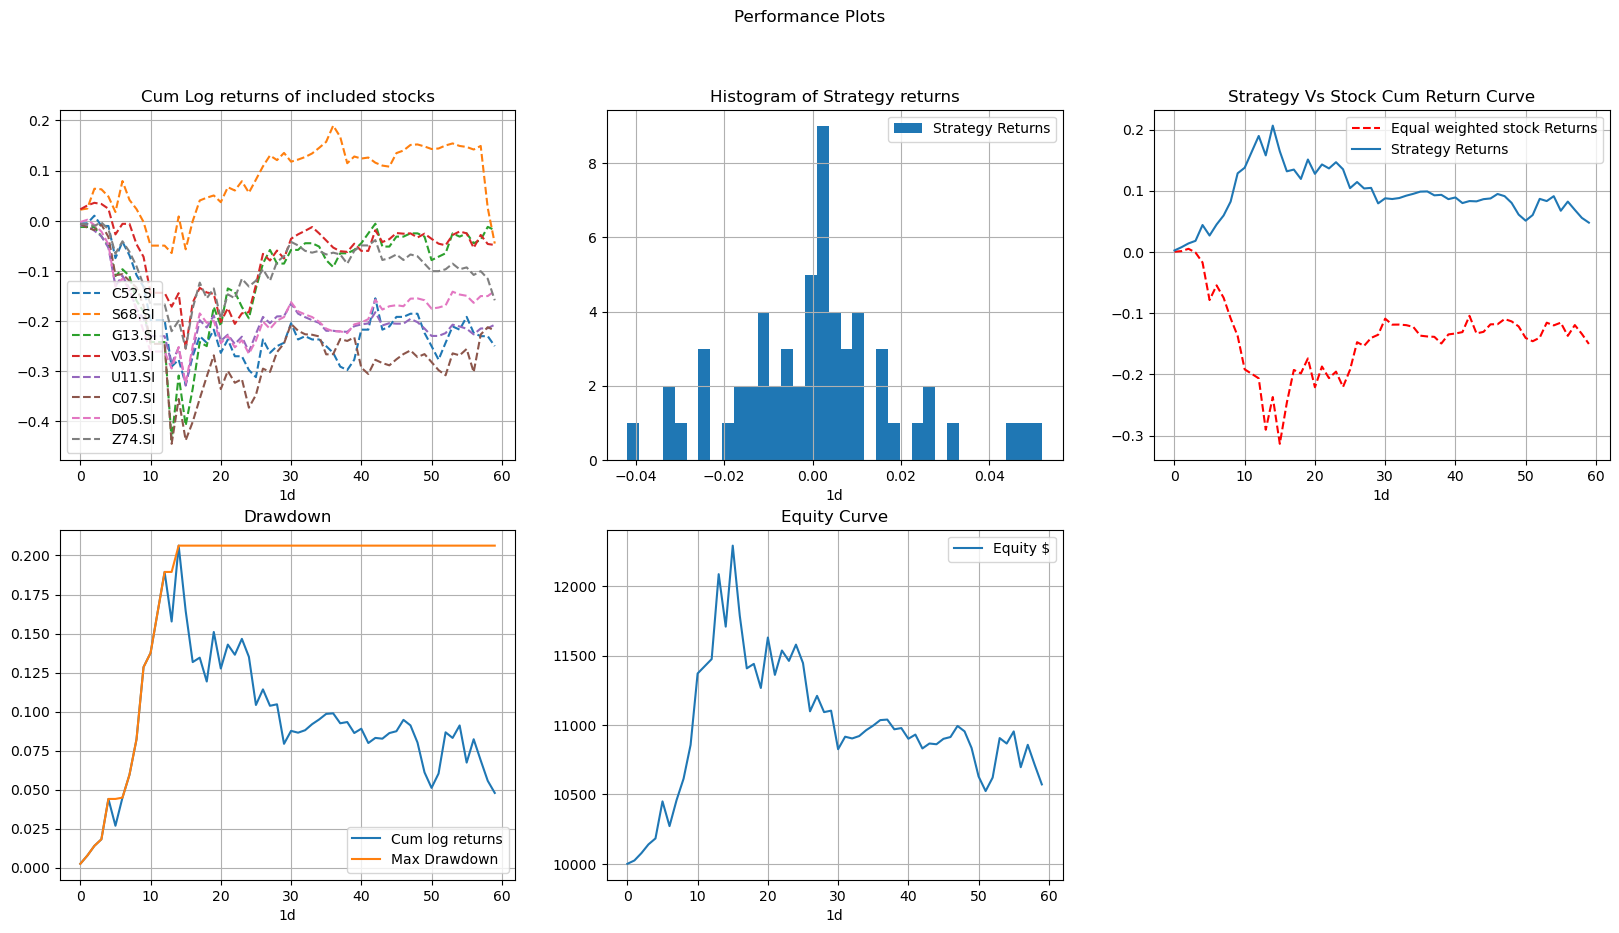

In [21]:
class MA_Strategy_2(Common_Class_2):

  def go_long(self, bar, stock, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      else:
        dollar = dollar
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      else:
        dollar = dollar
      self.sell_order(bar, stock, dollar = dollar)

  def run_strategy(self, STMA_window, LTMA_window): # add the parameters according to the strategy
    self.stop = False
    self.trades = 0

    #Preparing data with LTMA and STMA so that can check crossovers. Also initialising with 0 quantity and 0 position

    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0

      indicator_1 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = STMA_window, fillna= False)
      STMA = indicator_1.sma_indicator()

      indicator_2 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = LTMA_window, fillna= False)
      LTMA = indicator_2.sma_indicator()

      self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)] = STMA
      self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)] = LTMA

    for bar in range(LTMA_window, len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar
      #Making a func so that no trade if balance goes below 0

      tb = self.total_balance(bar)
      if tb< 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)

        if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
          if self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] > self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]:
             '''
             This is the area where we decide how much money to go with
             in this case it will be self.capital_allocation[stock] will replace the self.capital in the parameters. for shashanks code, he goes with all the capital for the go_long or the go_short function. 
             '''
             self.go_long(bar,stock, dollar = 'all') # go with equal money # Make sure to enter less than initila capital
             #print("--------")
             continue # as I am storing data for SR calculations. Dont wnat duplication

        if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
          if self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] < self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]:
            self.go_short(bar,stock, dollar = 'all') # go with equal money
            #print("--------")
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  # I have used continue in previous "if conditions", So if they didnt execute meaning no trade conditions that day ; trade = 0

    #print("=" *50)
    #print("End of last bar") Now the bar ends, bar is at the last bar value.
    #print("=" *50)
    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    #print(self.stored_data)
    #return self.stored_data, self.all_data

#stocks = ['MSFT', 'AAPL', 'TSLA']
#stocks = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS"]
#stocks = ["C52.SI", "S68.SI", "G13.SI", "V03.SI"]
#stocks = ['AAPL']

if __name__ == "__main__":
    #stocks = ['MSFT', 'AAPL', 'TSLA', 'DELL', 'GOOG']
    stocks = ["C52.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI"]
    capital_params = {
    "C52.SI": 0.25,  # 25% of the capital
    "S68.SI": 0.15,  # 15% of the capital
    "G13.SI": 0.10,  # 10% of the capital
    "V03.SI": 0.20,  # 20% of the capital
    "U11.SI": 0.05,  # 5% of the capital
    "C07.SI": 0.12,  # 12% of the capital
    "D05.SI": 0.08,  # 8% of the capital
    "Z74.SI": 0.05   # 5% of the capital
    }
    A = MA_Strategy_2(stocks, "2020-01-01", "2020-06-01","1d", 10000, 0.00, capital_params, True)
    A.run_strategy(10,40)
    A.performance()
    A.performance_plots()

  #UnboundLocalError: local variable 'bar' referenced before assignment
  # If duration of test or difference between start date aand end date is less than MA


In [1]:
class BaseClass():
  def __init__(self, symbol, start, end, interval, total_capital, transcation_cost, capital_params, verbose = True):
    """
    Purpose:
        Initializes the BaseClass object, setting up data and initial parameters for each stock symbol in the portfolio.

    Arguments:
        symbol (list): List of stock symbols to include in the portfolio.
        start (str): Start date for the backtest (format: "YYYY-MM-DD").
        end (str): End date for the backtest (format: "YYYY-MM-DD").
        interval (str): Data interval for fetching historical data (e.g., "1d" for daily).
        total_capital (float): Initial capital available for trading.
        transaction_cost (float): Transaction cost percentage for each trade.
        capital_params (dict): Dictionary with symbols as keys and capital allocation weights as values.
        verbose (bool): Flag to enable detailed output.

    Returns:
        None

    Example:
        baseclass = BaseClass(
            symbol=["AAPL", "GOOG"],
            start="2020-01-01",
            end="2021-01-01",
            interval="1d",
            total_capital=100000,
            transaction_cost=0.001,
            capital_params={"AAPL": 0.6, "GOOG": 0.4},
            verbose=True
        )
    """

    self.all_data ={}
    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.total_capital = total_capital
    self.transaction_cost = transcation_cost
    self.capital_params = capital_params
    self.verbose = verbose
    
    # setting up the other properties
    self.capital = {s: total_capital * capital_params[s] for s in self.symbol}
    self.position = {}
    self.quantity = {}
    self.trades = 0
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.prepare_data() # prepares the data


  def prepare_data(self):
    """
    Purpose:
        Fetches historical price data for each stock in `symbol` and calculates daily returns. Stores data in the `all_data` dictionary.

    Arguments:
        None

    Returns:
        None

    Example:
        common_class.prepare_data()
    """
    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Log_Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

  def get_total_capital(self):
    """
    Purpose:
        Calculates the total capital across all stocks in the portfolio by summing the individual capital allocations.

    Arguments:
        None

    Returns:
        float: Total capital across all stocks.

    Example:
        total_capital = common_class.get_total_capital()
    """
    return sum(self.capital.values())

#   def close_graph(self, stock):
#     i = str(stock)
#     plt.figure(figsize=(15, 5))
#     plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
#     plt.xlabel("Days")
#     plt.ylabel("Price")
#     plt.title("Close Prices of {}".format(i))
#     plt.legend()
#     plt.grid()
#     plt.show()

  # this will get the data price for individual stocks
  def return_date_price(self, time_index, stock):
    """
    Purpose:
        Retrieves the date and closing price of a specific stock at a given bar (time index).

    Arguments:
        time_index (int): Index representing the time position in the data.
        stock (str): The stock symbol for which to retrieve the data.

    Returns:
        tuple: Date (str) and closing price (float) of the stock at the specified bar.

    Example:
        date, price = common_class.return_date_price(10, "AAPL")
    """
    i = str(stock)
    date = str(self.all_data[i].index[time_index])[:10] # getting only the date portion of the timestamp
    price = self.all_data[i].Close_Price.iloc[time_index]
    return date, price

  def realised_balance(self, time_index):
    """
    Purpose:
        Prints the realised capital (cash) available in the account at a specific time index. Realised capital includes the profits or losses from trades that are fully executed

    Arguments:
        time_index (int): Index representing the time position in the data.

    Returns:
        None

    Example:
        common_class.realised_balance(10)
    """
    date, price = self.return_date_price(time_index, self.symbol[0])
    rb = self.get_total_capital()
    print(f"Date: {date} | Realised Balance: {rb:.1f}")

  def unrealised_balance(self, time_index):
    """
    Purpose:
        Calculates and prints the unrealised balance, which is the value of open positions (not yet settled trades) at a specific time index. 

    Arguments:
        time_index (int): Index representing the time position in the data.

    Returns:
        None

    Example:
        common_class.unrealised_balance(10)
    """
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(time_index, stock)
      ub =  ub + self.quantity[f'{stock}'] * price
    print(f"Date: {date} | Unrealised Balance: {ub:.1f}")

  def total_balance(self, time_index):
    """
    Purpose:
        Calculates the total balance as the sum of realised (cash) and unrealised (open positions) balances at a specific time index.

    Arguments:
        time_index (int): Index representing the time position in the data.

    Returns:
        float: Total balance (realised + unrealised) at the specified bar.

    Example:
        balance = common_class.total_balance(10)
    """
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(time_index, stock)
      ub =  ub + self.quantity[f'{stock}'] *price
    tb = ub + self.get_total_capital()
    print(f"Date: {date} | Total Balance: {tb:0.1f}")
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    """
    Purpose:
        Stores details of each trade in a DataFrame for performance and portfolio analysis

    Arguments:
        trade (int): The trade number or ID. 
            - Set to 0 if no trade occurred.
            - Set to a positive integer representing the current trade number if a trade has occurred.
        date (str): Date of the trade.
        position (int): Position type (1 for buy, -1 for sell).
        price (float): Price at which the trade occurred.
        symbol (str): The stock symbol traded.
        quantity (int): Quantity of shares traded.
        capital (float): Account balance after the trade.

    Returns:
        None

    Example:
        common_class.store_results(1, "2020-01-01", 1, 150.0, "AAPL", 10, 100000)
    """

    trade_detail = pd.DataFrame({
      'trade':pd.Series(trade),
      'date':pd.Series(date), 
      'position':pd.Series(position), 
      'price':pd.Series(price), 
      'symbol':pd.Series(symbol), 
      'quantity':pd.Series(quantity), 
      'capital':pd.Series(capital) 
    })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  # should be moved to backtester compilation function
  def performance_plots(self):

    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

    #f.tight_layout(h_pad=5, w_pad=2)

    #plot 1: Close Price of stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

# changed to store information for multiple stocks
# moved
  def performance(self):
    df = pd.DataFrame() 
    print(self.stored_data)
    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    print(df)

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time.
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Log_Returns'].tolist()) # The returns are already log
      df[f'Log_Returns_{stock}'] = A * capital_params[stock]
    print(df)
    
    c= df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()
    #print(df.head())

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.get_total_capital()))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.get_total_capital - self.total_capital) /self.total_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)-1

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,time_index,stock,quantity=None, dollar =None ):
    """
      Purpose:
          Executes a buy order for a specified quantity or dollar amount, updates the balance, and stores trade details.

      Arguments:
          bar (int): Index representing the time position in the data.
          stock (str): The stock symbol to buy.
          quantity (int, optional): Number of shares to buy.
          dollar (float, optional): Dollar amount to invest in the stock.

      Returns:
          None

      Example:
          common_class.buy_order(10, "AAPL", quantity=5)
      """
    # I want to implement a stop loss here. 
    date, price = self.return_date_price(time_index,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[stock] = self.capital[stock] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity[f'{stock}'] = self.quantity[f'{stock}'] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(time_index)
    self.store_results(self.trades, date, self.position[f'{stock}'], price, stock, quantity, tb)

    if self.verbose:
      print(f"Bought {quantity} shares of {stock} at {price:.1f} per share worth {quantity * price:.1f} $")
      print(f"Total quantity for {stock} is {self.quantity[stock]}")
      self.realised_balance(time_index)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,time_index,stock, quantity=None, dollar=None ):
    """
    Purpose:
        Executes a sell order for a specified quantity or dollar amount, updates the balance, and stores trade details.

    Arguments:
        bar (int): Index representing the time position in the data.
        stock (str): The stock symbol to sell.
        quantity (int, optional): Number of shares to sell.
        dollar (float, optional): Dollar amount to sell from the stock holdings.

    Returns:
        None

    Example:
        common_class.sell_order(10, "AAPL", quantity=5)
    """
    # stop loss function should be here
    date, price = self.return_date_price(time_index, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[stock] = self.capital[stock] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity[f'{stock}'] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(time_index)
    self.store_results(self.trades, date, self.position[f'{stock}'], price, stock, quantity, tb)


    if self.verbose:
      print(f"Sold {quantity} shares of {stock} at {price:.1f} per share worth {quantity * price:.1f} $")
      print(f"Total quantity for {stock} is {self.quantity[stock]}")
      self.realised_balance(time_index)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)

  def last_trade(self, bar):# this needs to be check for all open positions of all stocks
    """
    Purpose:
        Closes any open trades for all stocks at the end of the trading period, updates the balance, and stores final trade details.

    Arguments:
        bar (int): Index representing the time position in the data.

    Returns:
        None

    Example:
        common_class.last_trade(100)
    """

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital[stock] = self.capital[stock] + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
        #print("--------------Final Balance-----------")
        #self.total_balance(bar)
        #returns = (self.capital - self.initial_capital) /self.initial_capital *100
        #print("------------------------------")
        #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        #print("The strategy returns on investment are {:0.1f} %".format(returns))
        #print("Total trades by startegy are {:0.1f}".format(self.trades))

    #print("=" *50)
    #print("--------------Final Balance-----------")
    #tb = self.total_balance(bar)
    #print("Total balan from tb is ", tb)
    #print('self.capital is ', self.capital)
    #returns = (self.capital - self.initial_capital) /self.initial_capital *100
    #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
    #print("The strategy returns on investment are {:0.1f} %".format(returns))
    #print("Total trades by startegy are {:0.1f}".format(self.trades))
    #print("=" *50)


In [ ]:
class MA_Strategy_Base(BaseClass):
  
  def go_long(self, bar, stock, quantity = None, dollar = None):
    # if previously in a short position, clear 
    if self.position[f'{stock}'] == -1:
      self.position[f'{stock}'] = 0
      self.buy_order(bar,stock, quantity = -self.quantity[f'{stock}']) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      else:
        dollar = dollar
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position[f'{stock}'] == 1:
      self.position[f'{stock}'] = 0
      self.sell_order(bar,stock, quantity = self.quantity[f'{stock}']) #to clear previous long position
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      else:
        dollar = dollar
      self.sell_order(bar, stock, dollar = dollar)

  def strategy(self, STMA_window, LTMA_window): # add the parameters according to the strategy
    self.position = 0
    self.trades = 0
    self.capital = self.initial_capital

    indicator_1 = SMAIndicator(close = self.data ["Close_Price"], window = STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = self.data ["Close_Price"], window = LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    self.data["STMA"] = STMA
    self.data["LTMA"] = LTMA

    for bar in range(LTMA_window, len(self.data)): # from the available data bar to the last data bar
      date, price = self.return_date_price(bar)

      if self.position in [0,-1]: # checking no position or short position
        if self.data["STMA"].iloc[bar]>self.data["LTMA"].iloc[bar]:
          self.go_long(bar, dollar=5000) # go with all money # Make sure to enter less than initial capital
          # print("--------")
          continue # as I am storing data for SR calculations. Dont wnat duplication. Continue to make sure 0 is added only on no conditions day

      if self.position in [0,1]: # checking no position or long position
        if self.data["STMA"].iloc[bar]<self.data["LTMA"].iloc[bar]:
          self.go_short(bar, dollar =5000) # go with all money
          #print("--------")
          continue

      #-----Storing all the values for calculating Sharpe-----
      store_quantity = abs(self.quantity) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
      self.store_results(0, date, self.position, price, self.symbol, store_quantity, self.quantity*price + self.capital)

    print("=" *50)
    print("End of last bar")
    print("=" *50)
    self.last_trade(bar)  # make sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    print(self.stored_data)

In [ ]:
class EventBacktester():
    def __init__(self, strategy, capital_params, ):


    





In [ ]:
train_start = "2010-01-01"
train_end = "2016-12-31"

test_start = "2017-01-01"
test_end = "2019-12-31"

capital_params = {
    "AAPL": 0.3, 
    "AMZN": 0.5,
    "GOOG": 0.2
}

rsi_params = {
    'rsi_window': 14,
    'upper_limit': 10,
    'lower_limit': 10
}


if __name__ == "__main__":
    A = MA_Strategy(["AAPL", "AMZN", "GOOG"], "2010-01-01", "2016-12-31","1d",10000, 0.0, capital_params, True)
    E = EventBacktester(A)
    A.close_graph()
    A.run_strategy(50,200)
    A.performance()

In [ ]:
if __name__ == "__main__":
    RSIWeightedStrategy("AAPL", "2010-01-01", "2016-12-31","1d",10000, 0.0 , True)